In [2]:
import pysam
import os.path
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

# construct env file

In [3]:
ped = pd.read_csv(ped_genotypes, sep = ' ', skipinitialspace=True, header = None)
#ped.head()

In [4]:
ped = ped.iloc[:,0:2]
#ped.head()

In [5]:
POPINFO = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/POPINFO.txt', sep = '\t')
#POPINFO.head()

In [6]:
INDINFO = pd.merge(ped, POPINFO, left_on = 0, right_on = 'CLUSTER')
#INDINFO.head()

In [7]:
life_history_to_dummy = {'Summer': 1, 'Fall':2, 'Winter':3, 'UNK':2}
INDINFO['var'] = [life_history_to_dummy[xx] for xx in INDINFO['TIMING']]
#INDINFO

In [8]:
INDINFO['var'].to_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/LFMM/basic.env', index = False)

# Run LFMM - see R code

# Load LFMM results
see LEA_analysis.R and LEA_analysis.dom.R for details

In [9]:
lfmm = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/LFMM/lfmm_results.txt', sep = '\t')
lfmm['mlog10val'] = -np.log10(lfmm['cpvals'])

## determine candidates

In [10]:
import statsmodels.sandbox.stats.multicomp
reject_null, fdr_pval, alphacSidak, alphacBonf = statsmodels.sandbox.stats.multicomp.multipletests(lfmm['cpvals'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
lfmm['reject_null'] = reject_null
lfmm.head()

,locnum,cpvals,zscore,mlog10val,reject_null
0,1,0.429470,-0.846787,0.367067,False
1,2,0.780930,0.298061,0.107388,False
2,3,0.675836,-0.448154,0.170159,False
3,4,0.324520,1.055900,0.488759,False
4,5,0.716019,-0.389885,0.145075,False


In [11]:
non_paralogs_map = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/non_paralogs.map',sep = '\t', header = None)
non_paralogs_map.head()
non_paralogs_map.columns = ['plinkLG', 'stacksID', 'junk1', 'junk2']

In [12]:
lfmm_map = pd.merge(lfmm, non_paralogs_map, left_index=True, right_index=True)
lfmm_map.head()

,locnum,cpvals,zscore,mlog10val,reject_null,plinkLG,stacksID,junk1,junk2
0,1,0.429470,-0.846787,0.367067,False,0,1013_6,0,6
1,2,0.780930,0.298061,0.107388,False,0,2062_6,0,6
2,3,0.675836,-0.448154,0.170159,False,0,2574_6,0,6
3,4,0.324520,1.055900,0.488759,False,0,2741_6,0,6
4,5,0.716019,-0.389885,0.145075,False,0,4096_6,0,6


In [13]:
pop_fst = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/non_paralogs.fst', sep= '\t')
pop_fst.rename(columns = {'SNP':'stacks_SNP'}, inplace=True)
pop_fst.head()

,CHR,stacks_SNP,POS,NMISS,FST
0,0,1013_6,6,168,0.015589
1,0,2062_6,6,171,-0.002161
2,0,2574_6,6,169,0.017541
3,0,2741_6,6,166,-0.005708
4,0,4096_6,6,169,0.010227


In [14]:
lfmm_map = pd.merge(lfmm_map, pop_fst, left_on='stacksID', right_on='stacks_SNP')

In [15]:
linkage_map = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/linkage_map/LEPmap/with_paralogs/final/PS_chum_map_2015.txt',sep = '\t')
linkage_map.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM
0,c4311,4311,28282,28282_88,4584,1,0,1,0
1,c4311,4311,28282,28282_91,4584,1,0,1,0
2,c56875,56875,39970,39970_17,7377,1,0,1,0
3,c56875,56875,39970,39970_33,7377,1,0,1,0
4,c56875,56875,39970,39970_49,7377,1,0,1,0


In [16]:
mapped_lfmm = pd.merge(linkage_map, lfmm_map, left_on='stacks_SNP', right_on='stacksID', how = 'right')
mapped_lfmm.shape

(12399, 23)

In [17]:
mapped_lfmm = mapped_lfmm.sort(columns=['paper1_LG', 'cM'])
mapped_lfmm['manhattan_order'] = range(1, len(mapped_lfmm)+1)
mapped_lfmm.head()

/home/ipseg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,contig,resolved_locus,stacks_CatID,stacks_SNP_x,LEPname,LEP_LG,cM_OLD,paper1_LG,cM,locnum,...,plinkLG,stacksID,junk1,junk2,CHR,stacks_SNP_y,POS,NMISS,FST,manhattan_order
0,c4311,4311,28282,28282_88,4584,1,0,1,0,6440,...,1,28282_88,0,88,1,28282_88,88,156,0.013742,1
1,c56875,56875,39970,39970_60,7377,1,0,1,0,6348,...,1,39970_60,0,60,1,39970_60,60,152,0.016345,2
2,c54045,54045,37579,37579_17,6722,1,0,1,0,6197,...,1,37579_17,0,17,1,37579_17,17,164,0.028103,3
3,c2167,2167,10293,10293_9,1923,1,0,1,0,6162,...,1,10293_9,0,9,1,10293_9,9,162,0.014312,4
4,c69918,69918,50820,50820_7,10017,1,0,1,0,6154,...,1,50820_7,0,7,1,50820_7,7,169,0.015249,5


# Lets look at the allele frequencies of SNPs selected here

In [22]:
env = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/LFMM/basic.env', header = None)
env.columns = ['env']
env.head()

,env
0,1
1,1
2,1
3,1
4,1


In [77]:
ped_genotypes = '/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/non_paralogs.ped'
ped_genotypes = pd.read_csv(ped_genotypes, sep = ' ', header = None)
ped_genotypes = ped_genotypes.iloc[:,:1]
ped_genotypes.columns = ['pop']
ped_genotypes['env'] = env['env'].copy()
ped_genotypes.head()
ped_genotypes = ped_genotypes.drop_duplicates(subset = ['pop', 'env'])
ped_genotypes

,pop,env
0,1,1
20,2,3
37,3,2
57,4,2
89,5,1
120,6,2
131,7,2
145,8,2
153,9,2
166,10,2


In [ ]:
pop_freqs = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/non_paralogs.frq.strat', 
                        delim_whitespace = True, skipinitialspace=True, index_col=0)
pop_freqs = pop_freqs.reset_index()

In [85]:
env_freqs = pd.merge(pop_freqs, ped_genotypes, left_on = 'CLST', right_on='pop')
env_freqs.groupby('env')
env_freqs.head()

,SNP,CLST,A1,A2,MAF,MAC,NCHROBS,pop,env
0,1013_6,1,A,T,0.1111,4,36,1,1
1,2062_6,1,C,G,0.1750,7,40,1,1
2,2574_6,1,A,G,0.2895,11,38,1,1
3,2741_6,1,T,C,0.1250,5,40,1,1
4,4096_6,1,G,T,0.1316,5,38,1,1


In [117]:
top_snps = mapped_lfmm.dropna().sort_values(['mlog10val'], ascending=False)[:8]['stacks_SNP_x'].tolist()
top_freqs = env_freqs[[xx in top_snps for xx in env_freqs['SNP']]]
top_freqs.head()
top_freqs_to_plot = top_freqs.groupby(['SNP', 'env', 'pop']).mean()[['MAF']].reset_index()
top_freqs_to_plot.head()

,SNP,env,pop,MAF
0,16218_14,1,1,0.7308
1,16218_14,1,5,0.5417
2,16218_14,2,3,0.5250
3,16218_14,2,4,0.4516
4,16218_14,2,6,0.2273


In [160]:
random_snps = np.random.choice(mapped_lfmm.dropna()['stacks_SNP_x'], 8, replace=False)


random_freqs = env_freqs[[xx in random_snps for xx in env_freqs['SNP']]]
random_freqs.head()
random_freqs_to_plot = random_freqs.groupby(['SNP', 'env', 'pop']).mean()[['MAF']].reset_index()
random_freqs_to_plot.head()

,SNP,env,pop,MAF
0,2240_46,1,1,0.0750
1,2240_46,1,5,0.3261
2,2240_46,2,3,0.1316
3,2240_46,2,4,0.2500
4,2240_46,2,6,0.3000


In [141]:
xpoporder = top_freqs_to_plot.sort_values('env')['pop'].drop_duplicates().tolist()
xpopdict = dict(zip(xpoporder, range(1,11)))

#### The mapped SNPs with the largest LFMM z-scores

Notes:
    - all snps have decent overall frequency
    - patterns are not stricking
    - 

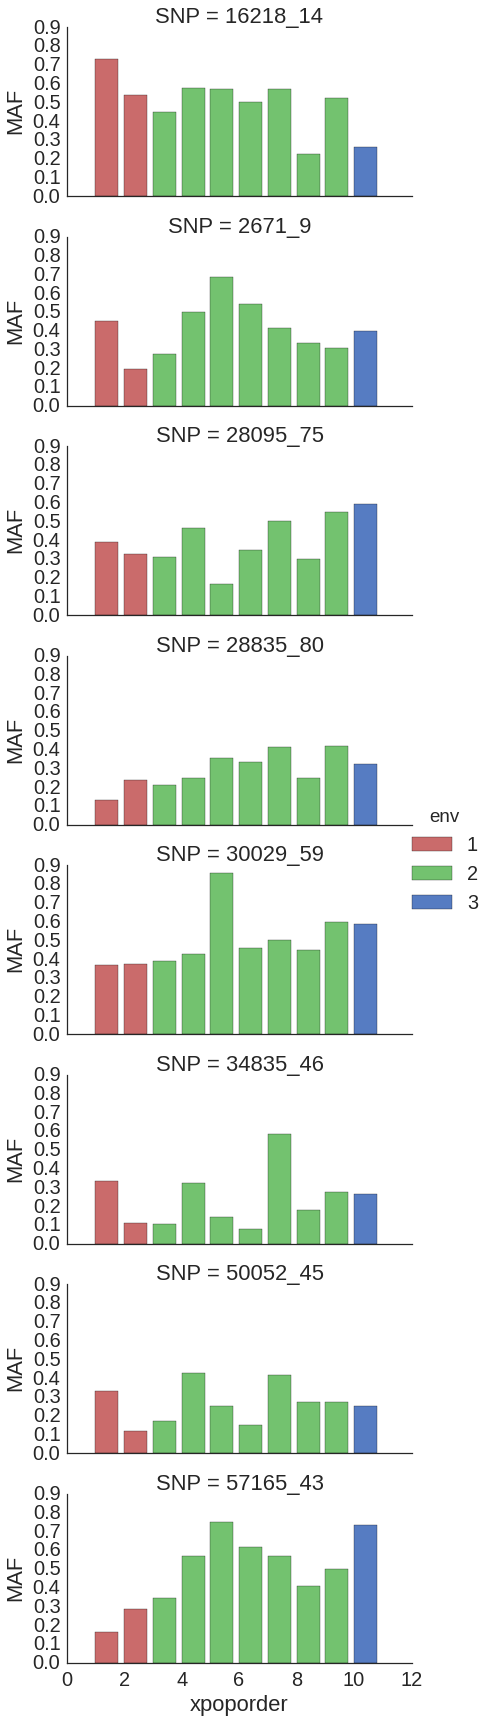

In [159]:
top_freqs_to_plot['xpoporder'] = [xpopdict[xx] for xx in top_freqs_to_plot['pop']]
g = sns.FacetGrid(data = top_freqs_to_plot, row = 'SNP', hue = 'env', 
                  size = 3, aspect = 2, palette = sns.color_palette("muted", n_colors=3, desat=.8)[::-1])
g = g.map(plt.bar, 'xpoporder', 'MAF').add_legend()

### Random SNPs

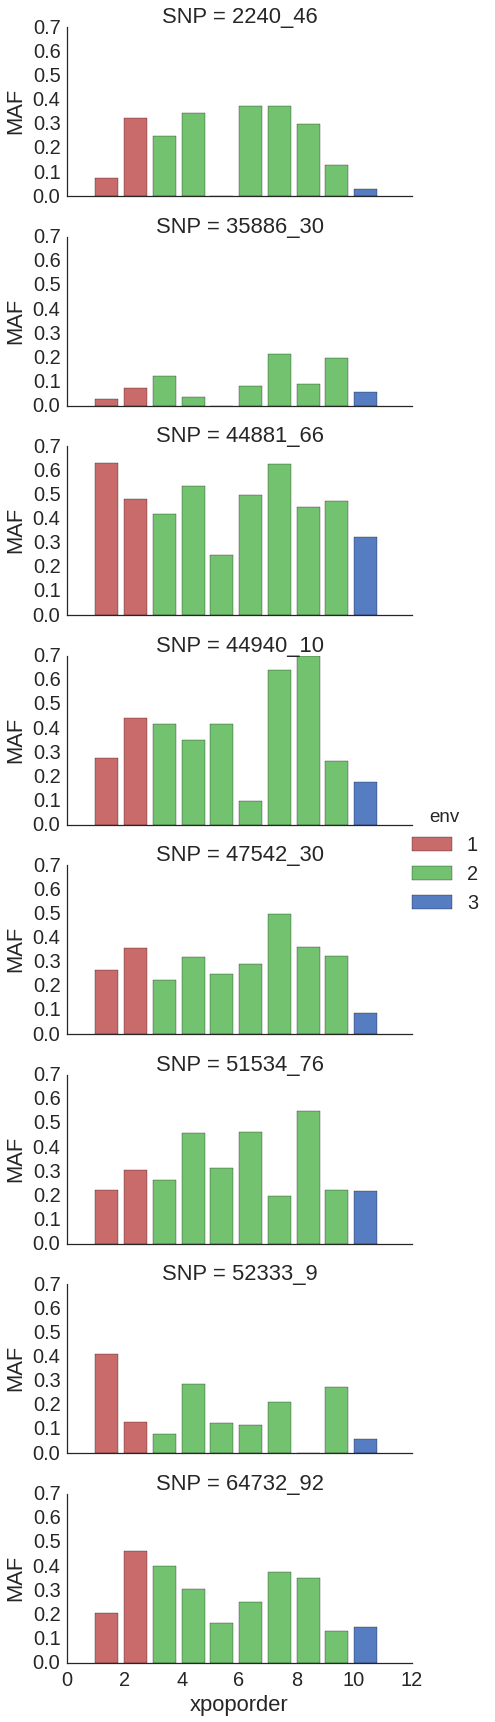

In [161]:
random_freqs_to_plot['xpoporder'] = [xpopdict[xx] for xx in random_freqs_to_plot['pop']]
g = sns.FacetGrid(data = random_freqs_to_plot, row = 'SNP', hue = 'env', 
                  size = 3, aspect = 2, palette = sns.color_palette("muted", n_colors=3, desat=.8)[::-1])
g = g.map(plt.bar, 'xpoporder', 'MAF').add_legend()

# Plots

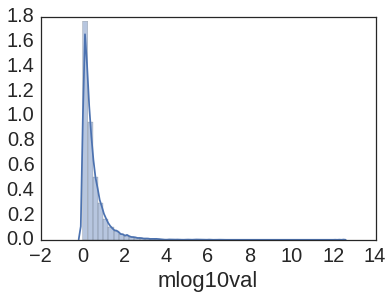

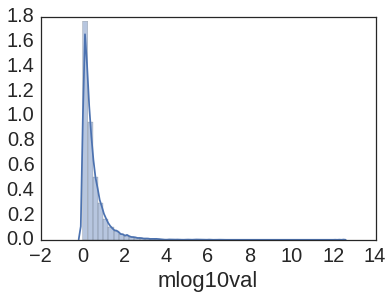

In [28]:
sns.distplot(lfmm['mlog10val'])
plt.show()
sns.distplot(mapped_lfmm['mlog10val'])
plt.show()

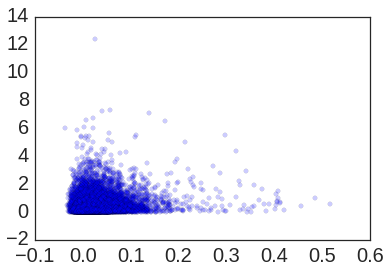

In [34]:
plt.scatter(x =mapped_lfmm['FST'] , y =mapped_lfmm['mlog10val'], alpha = .2)

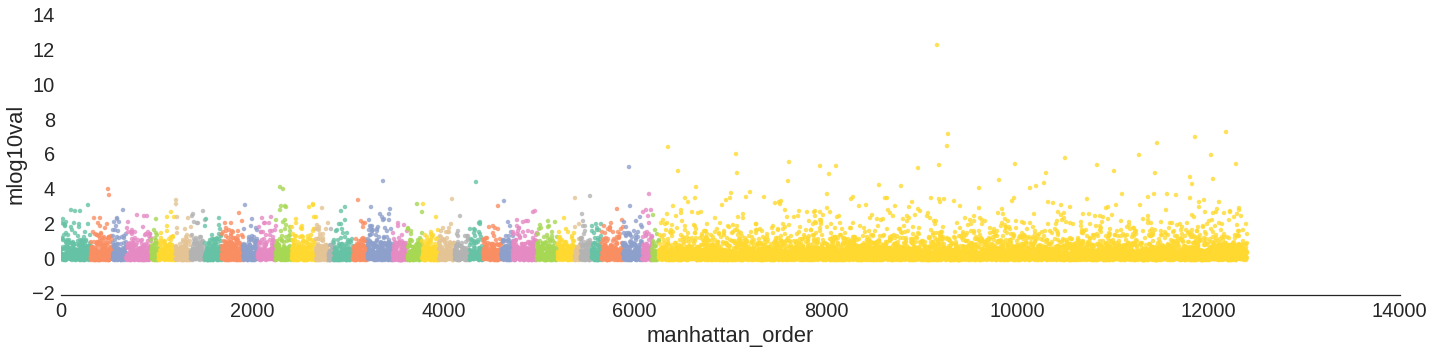

In [29]:
g = sns.lmplot(data = mapped_lfmm, x = 'manhattan_order', y = 'mlog10val', fit_reg=False, hue = 'plinkLG', sharex=False,
           legend= False, size = 5, aspect = 4, truncate = True,           palette="Set2")
g.set(xlim=0)
sns.despine(left=True)

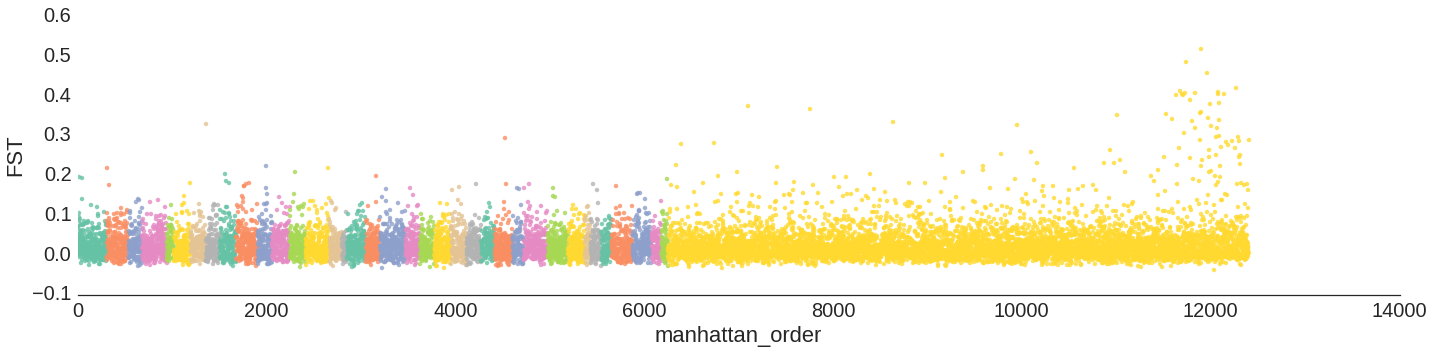

In [35]:
g = sns.lmplot(data = mapped_lfmm, x = 'manhattan_order', y = 'FST', fit_reg=False, hue = 'plinkLG', sharex=False,
           legend= False, size = 5, aspect = 4, truncate = True,           palette="Set2")
g.set(xlim=0)
sns.despine(left=True)

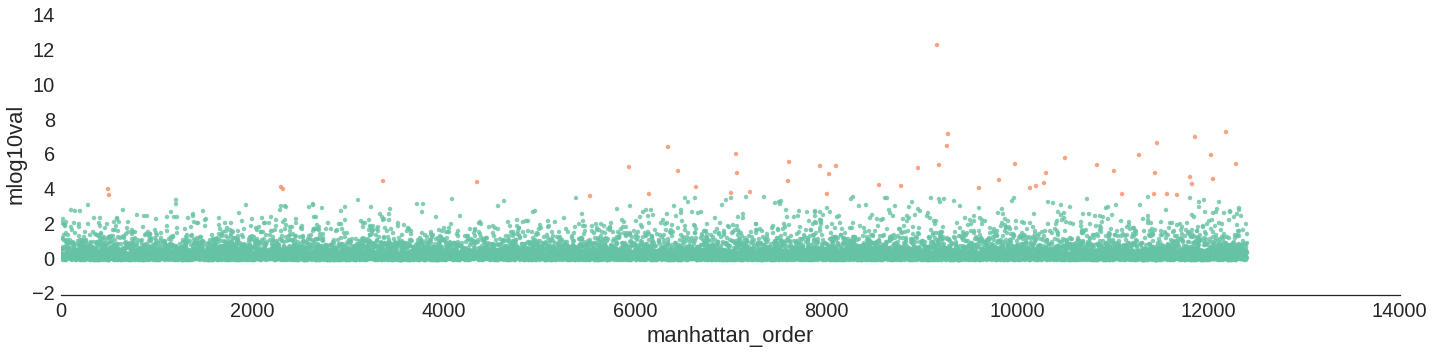

In [30]:
g = sns.lmplot(data = mapped_lfmm, x = 'manhattan_order', y = 'mlog10val', fit_reg=False, hue = 'reject_null', sharex=False,
           legend= False, size = 5, aspect = 4, truncate = True,           palette="Set2")
g.set(xlim=-1)
sns.despine(left=True)

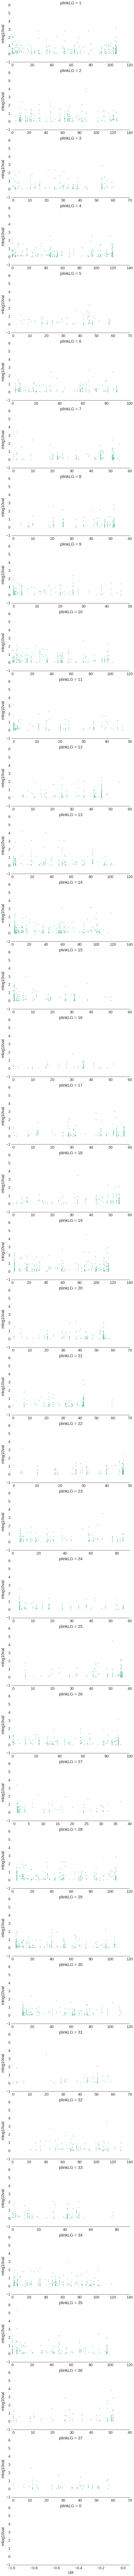

In [31]:
#figsize(10,10)
g = sns.lmplot(data = mapped_lfmm, x = 'cM', y = 'mlog10val', fit_reg=False, row = 'plinkLG', hue = 'reject_null', sharex=False,
           legend= False, size = 5, aspect = 2, 
           palette="Set2")
g.set(xlim=-1)
sns.despine(left=True)

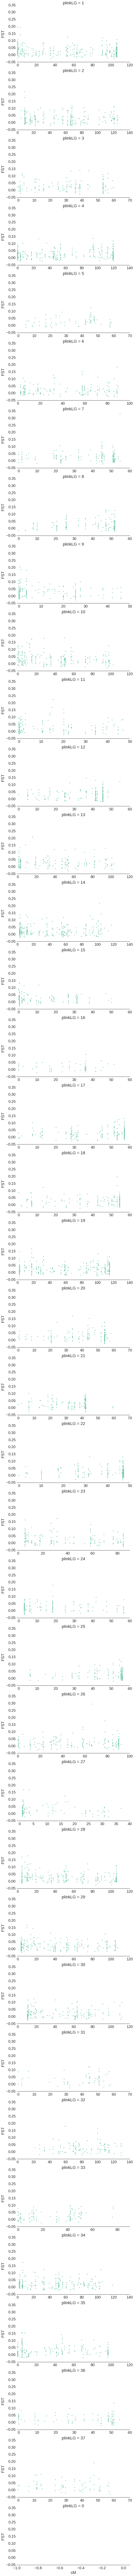

In [36]:
#figsize(10,10)
g = sns.lmplot(data = mapped_lfmm, x = 'cM', y = 'FST', fit_reg=False, row = 'plinkLG', hue = 'reject_null', sharex=False,
           legend= False, size = 5, aspect = 2, 
           palette="Set2")
g.set(xlim=-1)
sns.despine(left=True)